In [1]:
import logging
from copy import copy
from enum import Enum
from IPython.display import SVG,display
import pydot

import numpy as np
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         Concatenate, DiagramBuilder, InputPortIndex,
                         LeafSystem, MeshcatVisualizer, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, RandomGenerator, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix,
                         BsplineTrajectory, Sphere, Rgba,
                         KinematicTrajectoryOptimization, Solve, MinimumDistanceConstraint,
                         PositionConstraint)

from manipulation import FindResource, running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import (AddPackagePaths,
                                    MakeManipulationStation, AddIiwa, AddShape, AddWsg, AddMultibodyTriad)

class NoDiffIKWarnings(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('Differential IK')

logging.getLogger("drake").addFilter(NoDiffIKWarnings())

from utils import *

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7001/


The order of operations:
1. We start with comfortable joint angles for the iiwa q_throw and q_catch.
1. We use forward kinematics to get spatial positions p_WThrow and p_WCatch
1. we translate those by the offset between the ball and the gripper p_GB_G, to get the spatial positions the ball will be in at the point of being thrown (release) and caught X_WThrowB_W, X_WCatchB_W
1. we calculate using simple physics the spatial velocity of the ball at the point of being thrown and caught V_WThrowB_W, V_WCatchB_W, as well as the joint angle for the last iiwa link (rotation of the gripper such that it will parallel to the velocity of the ball), given a particular max height h that it reaches.
1. we use the Jacobian to transform the spatial velocities of the ball into joint velocities of the iiwa v_Throw and v_Catch, using the known offset between the gripper and the ball to create the Jacobian
1. We feed the joint positions and velocities into kin traj opt so they can be used as constraints to optimize the trajectory.


In [3]:
meshcat.Delete()

internal_model = make_internal_model()

squash_ball_radius = 0.02
p_GB_G = [0, 0.11, 0]
def add_target_objects(X_WThrow, X_WCatch):
    p_ThrowB_W = X_WThrow.rotation() @ p_GB_G
    X_WThrowB_W = RigidTransform(X_WThrow.rotation(), X_WThrow.translation() +  p_ThrowB_W)
    p_CatchB_W = X_WCatch.rotation() @ p_GB_G
    X_WCatchB_W = RigidTransform(X_WCatch.rotation(), X_WCatch.translation() +  p_CatchB_W)
    meshcat.SetObject("throw", Sphere(squash_ball_radius), rgba=Rgba(.9, .1, .1, 1))
    meshcat.SetTransform("throw", X_WThrowB_W)
    meshcat.SetObject("catch", Sphere(squash_ball_radius), rgba=Rgba(.1, .9, .1, 1))
    meshcat.SetTransform("catch", X_WCatchB_W)
    return X_WThrowB_W, X_WCatchB_W

q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
p_WThrow = [0.57, -0.34, 0.39]
R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.03])

q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
p_WCatch = [0.49, -0.45, 0.39]
R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.83])

X_WThrow = RigidTransform(R_WThrow, p_WThrow)
X_WCatch = RigidTransform(R_WCatch, p_WCatch)

X_WThrowB_W, X_WCatchB_W = add_target_objects(X_WThrow, X_WCatch)

max_height = 0.5 # Max height ball will reach in meters
V_ThrowB, V_CatchB, t_duration = calculate_ball_vels(X_WThrowB_W.translation(), X_WCatchB_W.translation(), max_height)
v_Throw = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_ThrowB, p_GB_G)
v_Catch = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_CatchB, p_GB_G)
# WSG gripper
opened = np.array([0.035])
closed = np.array([0.02])

In [4]:
def make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration):
    context = internal_model.CreateDefaultContext()
    plant = internal_model.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)
    
    # print(f"plant.num_positions()={plant.num_positions()}")
    # print(f"plant.GetPositionLowerLimits()={plant.GetPositionLowerLimits()}")
    # print(f"plant.GetVelocityUpperLimits()={plant.GetVelocityUpperLimits()}")

    num_control_points = 21
    num_positions = 7
    trajopt = KinematicTrajectoryOptimization(num_positions, num_control_points)
    prog = trajopt.get_mutable_prog()

    q_guess = np.tile(q_Catch.reshape((num_positions,1)), (1, trajopt.num_control_points()))
    q_guess[0,:] = np.linspace(q_Catch[0], q_Throw[0], trajopt.num_control_points())
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)
    
    trajopt.AddPathLengthCost(1)

    trajopt.AddPositionBounds(plant.GetPositionLowerLimits()[:num_positions],
                              plant.GetPositionUpperLimits()[:num_positions])
    trajopt.AddVelocityBounds(plant.GetVelocityLowerLimits()[:num_positions],
                              plant.GetVelocityUpperLimits()[:num_positions])

    trajopt.AddDurationConstraint(2 * t_duration, 2 * t_duration) # DIFF

    # constrain positions in joint angles
    trajopt.AddPathPositionConstraint(q_Catch, q_Catch, 0)
    trajopt.AddPathPositionConstraint(q_Throw, q_Throw, 0.5)
    trajopt.AddPathPositionConstraint(q_Catch, q_Catch, 1)

    prog.AddQuadraticErrorCost(np.eye(7), q_Catch,
                               trajopt.control_points()[:, 0])
    
    prog.AddQuadraticErrorCost(np.eye(7), q_Throw,
                               trajopt.control_points()[:, np.round(num_control_points/2).astype(int)])

    # return to start
    prog.AddQuadraticErrorCost(np.eye(7), q_Catch,
                               trajopt.control_points()[:, -1])
    

    v_Throw.reshape(7,1)
    v_Catch.reshape(7,1)
    trajopt.AddPathVelocityConstraint(v_Catch,v_Catch, 0)
    trajopt.AddPathVelocityConstraint(v_Throw,v_Throw, 0.5)
    trajopt.AddPathVelocityConstraint(v_Catch,v_Catch, 1)

    # print(prog)
    # Solve once without the collisions and set that as the initial guess for
    # the version with collisions.
    result = Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    
    traj = trajopt.ReconstructTrajectory(result)
    # print(f"kin traj opt initial t:{traj.start_time()} q: {traj.InitialValue()}")
    # print(f"kin traj opt final t:{traj.end_time()} q: {traj.FinalValue()}")
    return traj
    
    trajopt.SetPathInitialGuess(trajopt.ReconstructTrajectory(result))

    PublishPositionTrajectory(trajopt.ReconstructTrajectory(result), context, plant,
                              visualizer)
    collision_visualizer.Publish(
        collision_visualizer.GetMyContextFromRoot(context))

    
    # collision constraints
    collision_constraint = MinimumDistanceConstraint(plant, 0.001,
                                                     plant_context, None, 0.01)
    evaluate_at_s = np.linspace(0, 1, 25)
    for s in evaluate_at_s:
        trajopt.AddPathConstraint(collision_constraint, s)

    result = Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed")
        print(result.get_solver_id().name())

    PublishPositionTrajectory(trajopt.ReconstructTrajectory(result), context, plant,
                              visualizer)
    collision_visualizer.Publish(
        collision_visualizer.GetMyContextFromRoot(context))

In [5]:
class GraspSelector(LeafSystem):
    def __init__(self, plant, camera_body_indices):
        LeafSystem.__init__(self)
        model_point_cloud = AbstractValue.Make(PointCloud(0))
        self.DeclareAbstractInputPort("cloud0_W", model_point_cloud)
        self.DeclareAbstractInputPort("cloud1_W", model_point_cloud)
        self.DeclareAbstractInputPort("cloud2_W", model_point_cloud)
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))

        port = self.DeclareAbstractOutputPort(
            "ball_pose_estimate", lambda: AbstractValue.Make(
                (np.inf, RigidTransform())), self.BallPoseEstimate)
        port.disable_caching_by_default()

        # Compute crop box.
        context = plant.CreateDefaultContext()
        # bin_body = plant.GetBodyByName("bin_base", bin_instance)
        # X_B = plant.EvalBodyPoseInWorld(context, bin_body)
        # margin = 0.001  # only because simulation is perfect!
        # a = X_B.multiply([-.22+0.025+margin, -.29+0.025+margin, 0.015+margin])
        # b = X_B.multiply([.22-0.1-margin, .29-0.025-margin, 2.0])
        # self._crop_lower = np.minimum(a,b)
        # self._crop_upper = np.maximum(a,b)

        # self._internal_model = make_internal_model()
        # self._internal_model_context = self._internal_model.CreateDefaultContext()
        self._rng = np.random.default_rng()
        self._camera_body_indices = camera_body_indices


    def BallPoseEstimate(self, context, output): #time1 timestep time3 pos1 pos2
        body_poses = self.get_input_port(3).Eval(context)
        pcd = []
        for i in range(3):
            cloud = self.get_input_port(i).Eval(context)
            pcd.append(cloud.Crop(self._crop_lower, self._crop_upper))
            #pcd[i].EstimateNormals(radius=0.1, num_closest=30)

            # Flip normals toward camera
            #X_WC = body_poses[self._camera_body_indices[i]]
            #pcd[i].FlipNormalsTowardPoint(X_WC.translation())
        merged_pcd = Concatenate(pcd)
        pos = merged_pcd.xyzs()
        pos_ball = [sum(pos[0])/len(pos[0]),sum(pos[1])/len(pos[1]),sum(pos[2])/len(pos[2])]
        print (pos_ball)
        output.set_value(pos_ball)

        # pos1(x) @ (time1) =  
        # pos2(x) @ (time1+timestep)
        # pos1(y) @ (time1) =  
        # pos2(y) @ (time1+timestep)
        # pos1(z) @ (time1) =  
        # pos2(z) @ (time1+timestep)
        # estimate v2(x,y,z) from pos1 & pos2 & timestep
        # estimate pos3 (x,y,z) & v3 @ time+timestep or fix pos and estimate time3

        # given pos3, constraining r,p,y, select grasp with lowest cost
        # outputs to plannar




        #down_sampled_pcd = merged_pcd.VoxelizedDownSample(voxel_size=0.005)

        # costs = []
        # X_Gs = []
        # # TODO(russt): Take the randomness from an input port, and re-enable
        # # caching.
        # for i in range(100 if running_as_notebook else 2):
        #     cost, X_G = GenerateAntipodalGraspCandidate(
        #         self._internal_model, self._internal_model_context,
        #         down_sampled_pcd, self._rng)
        #     if np.isfinite(cost):
        #         costs.append(cost)
        #         X_Gs.append(X_G)

        # if len(costs) == 0:
        #     # Didn't find a viable grasp candidate
        #     X_WG = RigidTransform(RollPitchYaw(-np.pi / 2, 0, np.pi / 2),
        #                           [0.5, 0, 0.22])
        #     output.set_value((np.inf, X_WG))
        # else:
        #     best = np.argmin(costs)
        #     output.set_value((costs[best], X_Gs[best]))
    
# label generation for segmantation
# merged point cloud notebook (masking mustard bottle)
# know where the point cloud of the robot and subtract, 


In [6]:
rs = np.random.RandomState()  # this is for python
generator = RandomGenerator(rs.randint(1000))  # this is for c++

class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PERPETUAL_MOTION = 2
    THINKING = 3

class Planner(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))
        self._throw_pose_index = self.DeclareAbstractInputPort(
            "throw_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._catch_pose_index = self.DeclareAbstractInputPort(
            "catch_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state",
                                                            2).get_index()
        self._ball_pose_index = self.DeclareAbstractInputPort(
            "ball_pose",AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()

        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE))
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        self._times_index = self.DeclareAbstractState(AbstractValue.Make(
            {"initial": 0.0}))
        
        self._traj_start_time_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )

        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)

        # For Perpetual Motion mode.
        num_positions = 7
        self._iiwa_position_index = self.DeclareVectorInputPort(
            "iiwa_position", num_positions).get_index()
                
        self.DeclareVectorOutputPort("iiwa_position_command", num_positions,
                                     self.CalcIiwaPosition)
        
        self._traj_arm_q_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )

        self.DeclareInitializationUnrestrictedUpdateEvent(self.Initialize)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

    def Update(self, context, state):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        current_time = context.get_time()
        times = context.get_abstract_state(int(
            self._times_index)).get_value()

        if mode == PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            if context.get_time() - times["initial"] > 0.02:
                self.GoCatchThrow(context, state)
            return
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
            if traj_start_time + traj_q.end_time() <= current_time:
                state.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).set_value(current_time)
                # print("restarting loop")
                # self.GoCatchThrow(context, state)
            return
        return

    def GoCatchThrow(self, context, state):
        print("GoCatchThrow")
        
        current_time = context.get_time()
        q_traj = make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration)
        
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        
        state.get_mutable_abstract_state(int(
            self._mode_index)).set_value(
                PlannerState.PERPETUAL_MOTION)

        # WSG Gripper Trajectory
        throw_time = t_duration
        catch_time = t_duration*2
        buff = 0.05 # ball-park good buff value = 0.035
        # Throw - Catch - Throw
        # times = [0, catch_time-buff, catch_time, throw_time-buff, throw_time]
        # positions = np.hstack([[opened], [opened], [closed], [closed], [opened]])
        # Catch - Throw - Catch Original
        # times = [0, throw_time-buff, throw_time, catch_time-buff, catch_time]
        # positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        # Catch - Throw - Catch tuned
        times = [0, throw_time, throw_time+buff, catch_time-buff, catch_time]
        positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(times, positions)

        state.get_mutable_abstract_state(int(
            self._traj_wsg_index)).set_value(traj_wsg_command)

    def Plan(self, context, state):
        mode = copy(
            state.get_mutable_abstract_state(int(self._mode_index)).get_value())

    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.PERPETUAL_MOTION:
            traj_wsg = context.get_abstract_state(int(
                self._traj_wsg_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()

            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()-traj_start_time))
            return
        else:
            # Command the open position
            output.SetFromVector([closed])
            return

    def Initialize(self, context, state):
        # self.GoCatchThrow(context, state)
        pass

    def CalcIiwaPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                    self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()
            output.SetFromVector(
                traj_q.value(
                    context.get_time()-traj_start_time))
        else:
            output.SetFromVector(q_Catch)



/tmp/ipykernel_1278/2480728222.py:85: DrakeDeprecationWarning: (Deprecated) See ForcedPublish() 
*/ (Deprecated.)

Deprecated:
    Use ForcedPublish() instead This will be removed from Drake on or
    after 2023-03-01.
  collision_visualizer.Publish(
GoCatchThrow


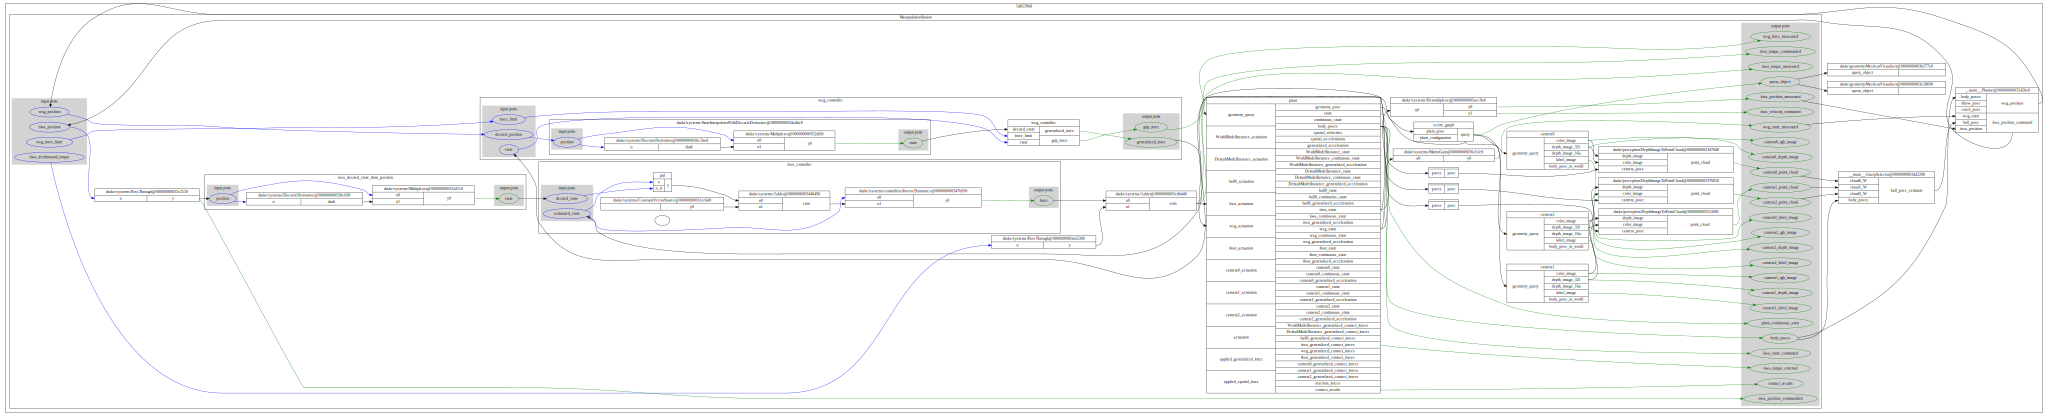

In [8]:
def clutter_clearing_demo():
    # meshcat.Delete()
    builder = DiagramBuilder()

    model_directives = """
directives:
"""

    for i in range(1 if running_as_notebook else 2):
        model_directives += f"""
- add_model:
    name: ball{i}
    file: package://one_arm_juggling/models/ball.sdf
"""
   
    # # estaiblishing ball_position_estimator 
    station = builder.AddSystem(
                        MakeManipulationStation(
                            model_directives,
                            filename="./models/one_arm_juggling.dmd.yaml",
                            package_xmls=["./package.xml"],
                            time_step=0.001))
    plant = station.GetSubsystemByName("plant")
   
    # # establishing planner
    planner = builder.AddSystem(Planner(plant))
    builder.Connect(station.GetOutputPort("body_poses"),
                    planner.GetInputPort("body_poses"))
    builder.Connect(station.GetOutputPort("wsg_state_measured"),
                    planner.GetInputPort("wsg_state"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    planner.GetInputPort("iiwa_position"))

    builder.Connect(planner.GetOutputPort("wsg_position"),
                    station.GetInputPort("wsg_position"))

    builder.Connect(planner.GetOutputPort("iiwa_position_command"),
                    station.GetInputPort("iiwa_position"))
    
    # # estaiblishing ball_position_estimator  
    ball_position_estimator = builder.AddSystem(
        GraspSelector(plant,
                      camera_body_indices=[
                          plant.GetBodyIndices(
                              plant.GetModelInstanceByName("camera0"))[0],
                          plant.GetBodyIndices(
                              plant.GetModelInstanceByName("camera1"))[0],
                          plant.GetBodyIndices(
                              plant.GetModelInstanceByName("camera2"))[0]
                      ]))
    builder.Connect(ball_position_estimator.get_output_port(),
                        planner.GetInputPort("ball_pose"))
    builder.Connect(station.GetOutputPort("camera0_point_cloud"),
                    ball_position_estimator.get_input_port(0))
    builder.Connect(station.GetOutputPort("camera1_point_cloud"),
                    ball_position_estimator.get_input_port(1))
    builder.Connect(station.GetOutputPort("camera2_point_cloud"),
                    ball_position_estimator.get_input_port(2))
    builder.Connect(station.GetOutputPort("body_poses"),
                    ball_position_estimator.GetInputPort("body_poses"))
    

   

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat)
    collision_visualizer = MeshcatVisualizer.AddToBuilder(
         builder, station.GetOutputPort("query_object"), meshcat,
        MeshcatVisualizerParams(prefix="collision", role=Role.kProximity))
    meshcat.SetProperty("collision", "visible", False)
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_context()

    plant_context = plant.GetMyMutableContextFromRoot(context)
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(X_WCatchB_W.rotation(), X_WCatchB_W.translation()) 
        # for starting from drop add to translation np.array([0,0,6])
        # np.array([0,0,-0.015])
        plant.SetFreeBodyPose(plant_context,
                              plant.get_body(body_index),
                              tf)

    collision_visualizer.Publish(
        collision_visualizer.GetMyContextFromRoot(context))
    
    q0 = plant.GetPositions(plant_context)
    non_iiwa_q0 = q0[7:]
    gap = closed[0]
    non_iiwa_q0[0]=-gap/2
    non_iiwa_q0[1]=gap/2
    plant.SetPositions(plant_context, np.concatenate((q_Catch, non_iiwa_q0)))
    simulator.AdvanceTo(0)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    RecordInterval(0, 2, simulator, context, plant, visualizer)
    # if running_as_notebook:
    #     simulator.set_target_realtime_rate(0.1)
    #     meshcat.AddButton("Stop Simulation", "Escape")
    #     print("Press Escape to stop the simulation")
    #     while meshcat.GetButtonClicks("Stop Simulation") < 1:
    #         simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
    #     meshcat.DeleteButton("Stop Simulation")
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
    pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_svg("diagram.svg")
clutter_clearing_demo()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a898be-bd4e-4046-916a-6293aadf6c5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>